In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
import numpy as np
import torch
import torch.nn as nn
from facenet_pytorch import fixed_image_standardization
from torchvision import transforms
from tqdm import tqdm

from data_loader import get_loader, read_dataset, CompositeDataset
from model import FaceRecognitionCNN
from utils import write_json, copy_file, count_parameters
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def tile(a, dim, n_tile):
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)]))
    return torch.index_select(a, dim, order_index)

In [3]:
class Encoder2DTransformer(nn.Module):
    def __init__(self, face_recognition_cnn_path=None):
        super(Encoder2DTransformer, self).__init__()

        face_cnn = FaceRecognitionCNN()
        
        if face_recognition_cnn_path is not None:
            face_cnn = nn.DataParallel(face_cnn)
            state_dict = torch.load(face_recognition_cnn_path, map_location='cpu')
            face_cnn.load_state_dict(state_dict)

        if face_recognition_cnn_path:
            self.encoder2d = nn.Sequential(*list(face_cnn.module.resnet.children()))[:-4]
        else:
            self.encoder2d = nn.Sequential(*list(face_cnn.resnet.children()))[:-4]
        #self.disc1 = nn.Sequential(*list(face_cnn.resnet.children()))[-4:]
        #self.disc2 = face_cnn.relu
        #self.disc3 = face_cnn.dropout
        #self.disc4 = face_cnn.fc
        #self.disc = nn.Sequential(*[disc1, disc2, disc3, disc4])
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=1792, nhead=4)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=4)
        self.fc = nn.Linear(1792, 5)
        self.relu = nn.ReLU()
    
    def forward(self, images):
        batch_size, num_channels, depth, height, width = images.shape
        images = images.permute(0, 2, 1, 3, 4)
        images = images.reshape(batch_size * depth, num_channels, height, width)
        out = self.encoder2d(images)
#         side = out.squeeze(3)
#         side = side.squeeze(2)
#         side = self.disc1(side)
#         side = self.disc2(side)
#         side = self.disc3(side)
#         side = self.disc4(side)
        out = out.reshape(batch_size, depth, 1792, 1, 1)
        out = out.squeeze(4)
        out = out.squeeze(3)
        out = out.permute(1, 0, 2)
        out = self.transformer_encoder(out)
        out = out.permute(1, 0, 2)
        out = out.index_select(1, torch.tensor([0]).to(device))
        out = out.squeeze()
        out = self.relu(out)
        out = self.fc(out)
        
        return  out

In [4]:
transform = transforms.Compose([
        transforms.Resize((160, 160)),
        np.float32,
        transforms.ToTensor(),
        fixed_image_standardization
    ])

In [5]:
datasets = read_dataset(
    '../dataset/mtcnn/', transform=transform,
    max_images_per_video=11, max_videos=1000,
    window_size=11, splits_path='../dataset/splits/'
)
# only neural textures c40 and original c40
datasets = {
    k: v for k, v in datasets.items() 
    if ('original' in k or 'neural' in k or 'face2face' in k or 'faceswap' in k or 'deepfakes' in k) and 'c23' in k
}
print('Using training data: ')
print('\n'.join(sorted(datasets.keys())))

trains, vals, tests = [], [], []
for data_dir_name, dataset in datasets.items():
    train, val, test = dataset
    # repeat original data multiple times to balance out training data
    compression = data_dir_name.split('_')[-1]
    num_tampered_with_same_compression = len({x for x in datasets.keys() if compression in x}) - 1
    count = 1 if 'original' not in data_dir_name else num_tampered_with_same_compression
    for _ in range(count):
        trains.append(train)
    vals.append(val)
    tests.append(test)
    
train_dataset, val_dataset, test_dataset = CompositeDataset(*trains), CompositeDataset(*vals), CompositeDataset(*tests)

['deepfakes_faces_c23', 'original_faces_c23', 'face2face_faces_c23', 'neural_textures_faces_c23', 'faceswap_faces_c23']
Using training data: 
deepfakes_faces_c23
face2face_faces_c23
faceswap_faces_c23
neural_textures_faces_c23
original_faces_c23


In [6]:
tqdm.write('train data size: {}, validation data size: {}'.format(len(train_dataset), len(val_dataset)))

train data size: 63320, validation data size: 7675


In [ ]:
train_loader = get_loader(
    train_dataset, 64, shuffle=True, num_workers=2
)
val_loader = get_loader(
    val_dataset, 64, shuffle=True, num_workers=2
)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('training on', device)
[device]

training on cuda


[device(type='cuda')]

In [ ]:
model = Encoder2DTransformer('./model/facenet/model.pt')
model = nn.DataParallel(model)
model.to(device)
#if args.freeze_first_epoch:
#for m in model.resnet.parameters():
#    m.requires_grad_(False)

In [ ]:
input_shape = next(iter(train_loader))[2].shape
print('input shape', input_shape)
# need to call this before summary!!!
model.eval()
# summary(model, input_shape[1:], batch_size=input_shape[0], device=device)
print('model params (trainable, total):', count_parameters(model))

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-5, weight_decay=1e-3
)

# decrease learning rate if validation accuracy has not increased
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=1/4, patience=2, verbose=True,
)

NameError: name 'model' is not defined

In [ ]:
def save_model_checkpoint(epoch, model, val_acc):
    
    model_dir = os.path.join('./model', 'enctrf')
    os.makedirs(model_dir, exist_ok=True)

    model_path = os.path.join(model_dir, f'model.pt')
    torch.save(model.state_dict(), model_path)

    model_info = {
        'epoch': epoch,
        'val_acc': val_acc[0],
        'model_str': str(model)
    }
    json_path = os.path.join(model_dir, 'info.json')
    write_json(model_info, json_path)

    #src_model_file = os.path.join('facenet', 'model.py')
    #dest_model_file = os.path.join(model_dir, 'model.py')
    #copy_file(src_model_file, dest_model_file)

    tqdm.write(f'New checkpoint saved at {model_path}')


def print_training_info(batch_accuracy, loss, step):
    log_info = 'Training - Loss: {:.4f}, Accuracy: {:.4f}'.format(loss.item(), batch_accuracy)
    tqdm.write(log_info)

    #writer.add_scalar('training loss', loss.item(), step)
    #writer.add_scalar('training acc', batch_accuracy, step)


def print_validation_info(criterion, device, model, val_loader, epoch, step):
    model.eval()
    with torch.no_grad():
        loss_values = []
        all_predictions = []
        all_targets = []
        targets = []
        outputs = []
        for video_ids, frame_ids, images, target in val_loader:
            images = images.to(device)
            target = target.to(device)
            target = target.long()
            output = model(images)
            loss = criterion(output, target)
            loss_values.append(loss.item())
            targets.append(target)
            outputs.append(output)
            #predictions = outputs > 0.0
            #all_predictions.append(predictions)
            #all_targets.append(targets)
            #if args.debug:
            #    tqdm.write(outputs)
            #    tqdm.write(predictions)
            #    tqdm.write(targets)
        
        val_loss = sum(loss_values) / len(loss_values)
        
        outputs = torch.cat(outputs, 0)
        targets = torch.cat(targets, 0)
        
        val_accuracy = float((outputs.argmax(1)).eq(targets).sum()) / len(targets)
        
        total_target = targets.unique(return_counts=True)[1]
        pristine = ((outputs.argmax(1) == 0) * (targets == 0)).sum() / total_target[0]
        face2face = ((outputs.argmax(1) == 1) * (targets == 1)).sum() / total_target[1]
        faceswap = ((outputs.argmax(1) == 2) * (targets == 2)).sum() / total_target[2]
        neural = ((outputs.argmax(1) == 3) * (targets == 3)).sum() / total_target[3]
        deepfake = ((outputs.argmax(1) == 4) * (targets == 4)).sum() / total_target[4]
        
        tqdm.write(
            'Validation - Loss: {:.3f}, Acc: {:.3f}, Pr: {:.3f}, Ff: {:.3f}, Fs: {:.3f}, Nt: {:.3f}, Df: {:.3f}'.format(
                val_loss, val_accuracy, pristine, face2face, faceswap, neural, deepfake
            )
        )
        
    return val_accuracy, pristine, face2face, faceswap, neural, deepfake

In [ ]:
total_step = len(train_loader)
step = 1
best_val_acc = 0.5
for epoch in range(10):
    for i, (video_ids, frame_ids, images, targets) in \
            tqdm(enumerate(train_loader), desc=f'training epoch {epoch}', total=len(train_loader)):
        model.train()
        # Set mini-batch dataset
        images = images.to(device)
        targets = targets.to(device)

        # Forward, backward and optimize
        outputs = model(images)
        targets = targets.long()
        loss = criterion(outputs, targets)
        model.zero_grad()
        loss.backward()
        optimizer.step()

        batch_accuracy = float((outputs.argmax(1)).eq(targets).sum()) / len(targets)
        
        

        # Print log info
        step += 1
        
        if (i + 1) % 300 == 0:
            print_training_info(batch_accuracy, loss, step)

        if (i + 1) % 300 == 0:
            val_acc, pr_acc, ff_acc, fs_acc, nt_acc, df_acc = print_validation_info(
                criterion, device, model, val_loader, epoch, step
            )
            if val_acc > best_val_acc:
                save_model_checkpoint(epoch, model, (val_acc, pr_acc, ff_acc, fs_acc, nt_acc, df_acc))
                best_val_acc = val_acc

    # validation step after full epoch
    val_acc, pr_acc, ff_acc, fs_acc, nt_acc, df_acc = print_validation_info(
        criterion, device, model, val_loader, epoch, step
    )
    lr_scheduler.step(val_acc)
    if val_acc > best_val_acc:
        save_model_checkpoint(epoch, model, (val_acc, pr_acc, ff_acc, fs_acc, nt_acc, df_acc))
        best_val_acc = val_acc

#    if epoch == 0:
#        for m in model.resnet.parameters():
#            m.requires_grad_(True)
#        tqdm.write('Fine tuning on')

In [9]:
model = Encoder2DTransformer()
model = nn.DataParallel(model)
state_dict = torch.load('./model/enctrf/model.pt', map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)

test_loader = get_loader(
    test_dataset, 32, shuffle=True, num_workers=2, drop_last=False
)
with torch.no_grad():
    loss_values = []
    all_predictions = []
    all_targets = []
    targets = []
    outputs = []
    for video_ids, frame_ids, images, target in tqdm(test_loader):
        images = images.to(device)
        target = target.to(device)
        target = target.long()
        output = model(images)
        targets.append(target)
        outputs.append(output)
        loss = criterion(output, target)
        loss_values.append(loss.item())

#                 predictions = outputs > 0.0
#                 all_predictions.append(predictions)
#                 all_targets.append(targets)

    val_loss = sum(loss_values) / len(loss_values)

    outputs = torch.cat(outputs, 0)
    targets = torch.cat(targets, 0)
        
    val_accuracy = float((outputs.argmax(1)).eq(targets).sum()) / len(targets)

    total_target = targets.unique(return_counts=True)[1]
    pristine = ((outputs.argmax(1) == 0) * (targets == 0)).sum() / total_target[0]
    face2face = ((outputs.argmax(1) == 1) * (targets == 1)).sum() / total_target[1]
    faceswap = ((outputs.argmax(1) == 2) * (targets == 2)).sum() / total_target[2]
    neural = ((outputs.argmax(1) == 3) * (targets == 3)).sum() / total_target[3]
    deepfake = ((outputs.argmax(1) == 4) * (targets == 4)).sum() / total_target[4]
    tqdm.write(
        'Test - Loss: {:.3f}, Acc: {:.3f}, Pr: {:.3f}, Ff: {:.3f}, Fs: {:.3f}, Nt: {:.3f}, Df: {:.3f}'.format(
            val_loss, val_accuracy, pristine, face2face, faceswap, neural, deepfake
        )
    )

100%|██████████| 240/240 [01:43<00:00,  2.33it/s]

Test - Loss: 1.288, Acc: 0.771, Pr: 0.902, Ff: 0.778, Fs: 0.819, Nt: 0.502, Df: 0.853


In [10]:
cm = confusion_matrix(targets.cpu().numpy(), outputs.cpu().argmax(1).numpy())

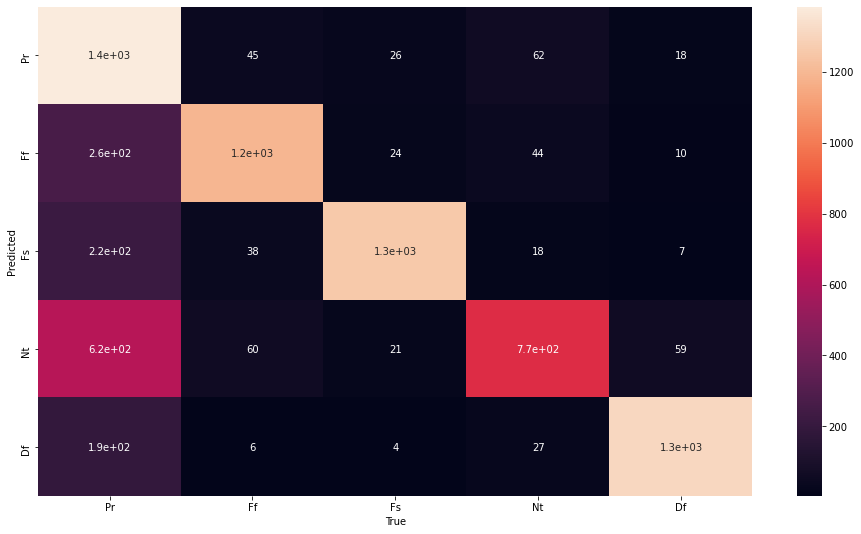

In [11]:
fig, ax = plt.subplots(figsize=(16,9));
ax = sns.heatmap(cm, xticklabels = ['Pr', 'Ff', 'Fs', 'Nt', 'Df'], yticklabels = ['Pr', 'Ff', 'Fs', 'Nt', 'Df'], annot = True);
ax.set(xlabel = 'True', ylabel = 'Predicted');